# Лабораторная работа №5 

## Ишков Денис Олегович, ИУ5-24М, 2021г.

## Тема: Предобработка текста
## Цель: Изучение методов предобработки текстов..
Требования к отчету:
Отчет по лабораторной работе должен содержать:
* титульный лист;
* описание задания;
* текст программы;
* экранные формы с примерами выполнения программы.
Задание:

Для произвольного предложения или текста решите следующие задачи:

* Токенизация.
* Частеречная разметка.
* Лемматизация.
* Выделение (распознавание) именованных сущностей.
* Разбор предложения.


## Датасет

Бинарная классификация текста

https://www.kaggle.com/blackmoon/russian-language-toxic-comments

In [1]:
# загрузка датасета
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/wedARfrtMn-Y-Q) -o labeled.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 4560k  100 4560k    0     0  1161k      0  0:00:03  0:00:03 --:--:-- 1720k


# Импорт нужных библиотек

In [143]:
import nltk
import spacy
import numpy as np
from tqdm.notebook import tqdm
nltk.download('punkt')
from nltk import tokenize
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, classification_report
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Анализ и обработка выбросов в данных

In [4]:
df = pd.read_csv("labeled.csv", sep=",")

df.describe()

,toxic
count,14412.000000
mean,0.334860
std,0.471958
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<AxesSubplot:ylabel='Frequency'>

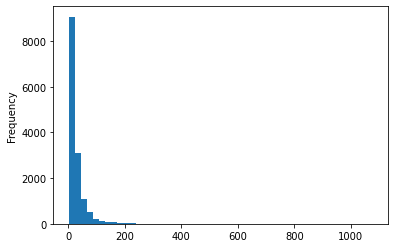

In [5]:
df.comment.str.split(' ').apply(len).plot(kind='hist', bins=50)

Как видно из гистограммы, количество слов сообщений в данных распределено по экспоненциальному закону. Уберём "хвост"

<AxesSubplot:ylabel='Frequency'>

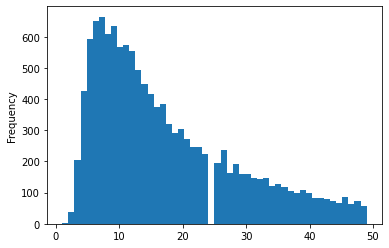

In [6]:
df = df[df.comment.str.split(' ').apply(len) < 50].copy()
df.comment.str.split(' ').apply(len).plot(kind='hist', bins=50)

In [7]:
df["toxic"] = df["toxic"].apply(int)
df["toxic"].value_counts()

0    8102
1    4419
Name: toxic, dtype: int64

# 1. Токенизация

In [9]:
print('Токенизаторы NLTK')
for i in dir(tokenize)[:16]:
    print(i)

Токенизаторы NLTK
BlanklineTokenizer
LineTokenizer
MWETokenizer
PunktSentenceTokenizer
RegexpTokenizer
ReppTokenizer
SExprTokenizer
SpaceTokenizer
StanfordSegmenter
StanfordTokenizer
TabTokenizer
TextTilingTokenizer
ToktokTokenizer
TreebankWordTokenizer
TweetTokenizer
WhitespaceTokenizer


In [67]:
comment = df.comment.values[222]
print(comment)
cleaned_comment = re.sub('[^а-яА-Яa-zA-Z0-9 \n\.]', '', comment)
print(cleaned_comment)

Бросила. Во время каждого занятия получала небольшие травмы, в последний раз при выполнении Сурьи Намаскар растянула связки на руке, боль была такая, что в первые секунды на перелом подумала. Теперь дома занимаюсь без напряга со стороны тренера.

Бросила. Во время каждого занятия получала небольшие травмы в последний раз при выполнении Сурьи Намаскар растянула связки на руке боль была такая что в первые секунды на перелом подумала. Теперь дома занимаюсь без напряга со стороны тренера.



In [22]:
tokenizer_wp = nltk.WhitespaceTokenizer()
tokens = tokenizer_wp.tokenize(cleaned_comment)
tokens

['Бросила.',
 'Во',
 'время',
 'каждого',
 'занятия',
 'получала',
 'небольшие',
 'травмы',
 'в',
 'последний',
 'раз',
 'при',
 'выполнении',
 'Сурьи',
 'Намаскар',
 'растянула',
 'связки',
 'на',
 'руке',
 'боль',
 'была',
 'такая',
 'что',
 'в',
 'первые',
 'секунды',
 'на',
 'перелом',
 'подумала.',
 'Теперь',
 'дома',
 'занимаюсь',
 'без',
 'напряга',
 'со',
 'стороны',
 'тренера.']

In [23]:
tokenizer_wp = nltk.WordPunctTokenizer()
tokens = tokenizer_wp.tokenize(cleaned_comment)
tokens

['Бросила',
 '.',
 'Во',
 'время',
 'каждого',
 'занятия',
 'получала',
 'небольшие',
 'травмы',
 'в',
 'последний',
 'раз',
 'при',
 'выполнении',
 'Сурьи',
 'Намаскар',
 'растянула',
 'связки',
 'на',
 'руке',
 'боль',
 'была',
 'такая',
 'что',
 'в',
 'первые',
 'секунды',
 'на',
 'перелом',
 'подумала',
 '.',
 'Теперь',
 'дома',
 'занимаюсь',
 'без',
 'напряга',
 'со',
 'стороны',
 'тренера',
 '.']

Делаем вывод, что WordPunctTokenizer подходит лучше

# 2. Частеречная разметка (POStagging)

In [27]:
!pip install natasha

     |████████████████████████████████| 34.4 MB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 3.5 MB/s  eta 0:00:01
     |████████████████████████████████| 55 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 41 kB 72 kB/s s eta 0:00:01
     |████████████████████████████████| 8.2 MB 42.0 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=d85aee54dead03a93b816c9de6743098922292053c9314a9f03cc10fa4608bae
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [33]:
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)

doc = Doc(cleaned_text)
doc.segment(segmenter)
print(doc.tokens)
doc.tag_morph(morph_tagger)
doc.sents[1].morph.print()

[DocToken(stop=7, text='Бросила'), DocToken(start=7, stop=8, text='.'), DocToken(start=9, stop=11, text='Во'), DocToken(start=12, stop=17, text='время'), DocToken(start=18, stop=25, text='каждого'), DocToken(start=26, stop=33, text='занятия'), DocToken(start=34, stop=42, text='получала'), DocToken(start=43, stop=52, text='небольшие'), DocToken(start=53, stop=59, text='травмы'), DocToken(start=60, stop=61, text='в'), DocToken(start=62, stop=71, text='последний'), DocToken(start=72, stop=75, text='раз'), DocToken(start=76, stop=79, text='при'), DocToken(start=80, stop=90, text='выполнении'), DocToken(start=91, stop=96, text='Сурьи'), DocToken(start=97, stop=105, text='Намаскар'), DocToken(start=106, stop=115, text='растянула'), DocToken(start=116, stop=122, text='связки'), DocToken(start=123, stop=125, text='на'), DocToken(start=126, stop=130, text='руке'), DocToken(start=131, stop=135, text='боль'), DocToken(start=136, stop=140, text='была'), DocToken(start=141, stop=146, text='такая'),

# 3. Лемматизация (Lemmatization)

In [35]:
morph_vocab = MorphVocab()
for token in doc.tokens:
    token.lemmatize(morph_vocab)
{_.text: _.lemma for _ in doc.tokens}

{'Бросила': 'бросить',
 '.': '.',
 'Во': 'в',
 'время': 'время',
 'каждого': 'каждый',
 'занятия': 'занятие',
 'получала': 'получать',
 'небольшие': 'небольшой',
 'травмы': 'травма',
 'в': 'в',
 'последний': 'последний',
 'раз': 'раз',
 'при': 'при',
 'выполнении': 'выполнение',
 'Сурьи': 'сурья',
 'Намаскар': 'намаскар',
 'растянула': 'растянуть',
 'связки': 'связка',
 'на': 'на',
 'руке': 'рука',
 'боль': 'боль',
 'была': 'быть',
 'такая': 'такой',
 'что': 'что',
 'первые': 'первый',
 'секунды': 'секунда',
 'перелом': 'перелом',
 'подумала': 'подумать',
 'Теперь': 'теперь',
 'дома': 'дома',
 'занимаюсь': 'заниматься',
 'без': 'без',
 'напряга': 'напряга',
 'со': 'с',
 'стороны': 'сторона',
 'тренера': 'тренер'}

# Выделение (распознавание) именованных сущностей (NER)

In [36]:
ner_tagger = NewsNERTagger(emb)
doc.tag_ner(ner_tagger)
doc.tag_ner(ner_tagger)
doc.ner.print()

Бросила. Во время каждого занятия получала небольшие травмы в 
последний раз при выполнении Сурьи Намаскар растянула связки на руке 
                             PER───────────                          
боль была такая что в первые секунды на перелом подумала. Теперь дома 
занимаюсь без напряга со стороны тренера.


In [74]:
text = '''Курская битва (5 июля — 23 августа 1943 года; также известна как Битва на Курской дуге) — совокупность стратегических оборонительной (5—23 июля) и наступательных (12 июля — 23 августа) операций Красной армии в Великой Отечественной войне с целью сорвать крупное наступление сил вермахта и разгромить его стратегическую группировку[9]. По своим масштабам, задействованным силам и средствам, напряжённости, результатам и военно-политическим последствиям является одним из ключевых сражений Второй мировой войны и Великой Отечественной войны. В историографии считается самым крупным (величайшим) танковым сражением в истории[10][11][12][13][14][Прим. 1]. В нём участвовали около 2 млн человек, 6 тысяч танков, 4 тысячи самолётов; сражение проложило «путь к великим советским наступательным действиям 1944-45 годов».
Сражение является важнейшей частью стратегического плана летне-осенней кампании 1943 года, согласно советской и российской историографии, включает в себя: Курскую стратегическую оборонительную операцию (5—23 июля), Орловскую (12 июля — 18 августа) и Белгородско-Харьковскую (3—23 августа) стратегические наступательные операции. Битва продолжалась 50 дней. Немецкая сторона наступательную часть сражения называла операция «Цитадель».
В результате наступления по плану «Кутузов» потерпела поражение орловская группировка немецких войск, а занимаемый ею орловский стратегический плацдарм был ликвидирован. По итогам операции «Румянцев» потерпела поражение белгородско-харьковская группировка немцев, и соответствующий плацдарм также был ликвидирован[15]. Коренной перелом в ходе Великой Отечественной войны, начатый под Сталинградом, был завершён в Курской битве и сражении за Днепр, а в последовавшей Тегеранской конференции по инициативе Ф. Рузвельта уже обсуждался составленный им лично «2 месяца тому назад план расчленения Германии на пять государств».
После завершения битвы стратегическая инициатива окончательно перешла на сторону Красной армии, которая продолжала освобождать страну от немецких захватчиков и до окончания войны проводила в основном наступательные операции. Вермахт в ходе отступления с территории СССР проводил тактику «выжженной земли»[16].
23 августа — день разгрома советскими войсками немецких войск в Курской битве — является одним из дней воинской славы России. Белгород, Курск и Орёл стали первыми городами России, которым присвоено почётное звание «Город воинской славы»[17].'''
doc2 = Doc(text)
doc2.segment(segmenter)
doc2.tag_morph(morph_tagger)
#doc2.sents[1].morph.print()
for token in doc.tokens:
    token.lemmatize(morph_vocab)
doc2.tag_ner(ner_tagger)
doc2.ner.print()

Курская битва (5 июля — 23 августа 1943 года; также известна как Битва
 на Курской дуге) — совокупность стратегических оборонительной (5—23 
июля) и наступательных (12 июля — 23 августа) операций Красной армии в
                                                       ORG──────────  
 Великой Отечественной войне с целью сорвать крупное наступление сил 
вермахта и разгромить его стратегическую группировку[9]. По своим 
масштабам, задействованным силам и средствам, напряжённости, 
результатам и военно-политическим последствиям является одним из 
ключевых сражений Второй мировой войны и Великой Отечественной войны. 
В историографии считается самым крупным (величайшим) танковым 
сражением в истории[10][11][12][13][14][Прим. 1]. В нём участвовали 
около 2 млн человек, 6 тысяч танков, 4 тысячи самолётов; сражение 
проложило «путь к великим советским наступательным действиям 1944-45 
годов».
Сражение является важнейшей частью стратегического плана летне-осенней
 кампании 1943 года, согласно сов

In [84]:
names_extractor = NamesExtractor(morph_vocab)
for span in doc2.spans:
    span.normalize(morph_vocab)
{_.text: _.normal for _ in doc2.spans if _.text != _.normal}

{'Красной армии': 'Красная армия',
 'Орловскую': 'Орловская',
 'Сталинградом': 'Сталинград',
 'Ф. Рузвельта': 'Ф. Рузвельт',
 'Германии': 'Германия',
 'России': 'Россия',
 'Орёл': 'Орел'}

# 5. Разбор предложения

In [86]:
doc.parse_syntax(syntax_parser)
doc.sents[1].syntax.print()

        ┌──────────► Во         case
        │            время      
        │         ┌► каждого    det
        │       ┌►└─ занятия    obl
┌─┌─┌─┌─│ ┌─┌─┌─└─── получала   
│ │ │ │ │ │ │ │   ┌► небольшие  amod
│ │ │ │ │ │ │ └──►└─ травмы     obj
│ │ │ │ │ │ │   ┌──► в          case
│ │ │ │ │ │ │   │ ┌► последний  amod
│ │ │ │ │ │ └──►└─└─ раз        obl
│ │ │ │ │ │       ┌► при        case
│ │ │ │ └─└────►┌─└─ выполнении obl
│ │ │ │         └►┌─ Сурьи      nmod
│ │ │ │           └► Намаскар   flat:name
│ │ │ │       ┌────► растянула  obl
│ │ │ └──────►│ ┌─── связки     nsubj
│ │ │         │ │ ┌► на         case
│ │ │         │ └►└─ руке       nmod
│ │ │         │ ┌─┌► боль       nsubj
│ │ └────────►│ │ │  была       conj
│ │         ┌─└─└►└─ такая      det
│ │         │ ┌────► что        obj
│ │         │ │ ┌──► в          case
│ │         │ │ │ ┌► первые     amod
│ └────────►│ │ └─└─ секунды    obl
│           │ │   ┌► на         case
│           │ │ ┌►└─ перелом    obl
│           

# 

# Лабораторная работа №6 

## Ишков Денис Олегович, ИУ5-24М, 2021г.

## Тема: Классификация текста
## Цель: Изучение методов классификации текстов.
Требования к отчету:
Отчет по лабораторной работе должен содержать:
* титульный лист;
* описание задания;
* текст программы;
* экранные формы с примерами выполнения программы.
Задание:

Для произвольного набора данных, предназначенного для классификации текстов,
решите задачу классификации текста двумя способами:

* Способ 1. На основе CountVectorizer или TfidfVectorizer.
* Способ 2. На основе моделей word2vec или Glove или fastText.
* Сравните качество полученных моделей.

Для поиска наборов данных в поисковой системе можно использовать ключевые слова "datasets for text classification".

### Разделим данные на обучающую и тестовую выборки

In [88]:
train_df, test_df = train_test_split(df, test_size=500, random_state=69, stratify=df.toxic)

In [90]:
test_df["toxic"].value_counts(), train_df["toxic"].value_counts()

(0    324
 1    176
 Name: toxic, dtype: int64,
 0    7778
 1    4243
 Name: toxic, dtype: int64)

# Предобработка текста

In [91]:
sentence_example = df.iloc[-1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [92]:
print(f"Исходный текст: {sentence_example}")
print("-----------------")
print(f"Токены: {tokens}")
print("-----------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-----------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-----------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-----------------")

Исходный текст: До сих пор пересматриваю его видео. Орамбо кстати на своем канале пилит похожий контент, но качеством похуже, там же и Шуран не редко светится, храню хрупкую надежду что когда-то он вернется, такая годнота ведь.

-----------------
Токены: ['До', 'сих', 'пор', 'пересматриваю', 'его', 'видео', '.', 'Орамбо', 'кстати', 'на', 'своем', 'канале', 'пилит', 'похожий', 'контент', ',', 'но', 'качеством', 'похуже', ',', 'там', 'же', 'и', 'Шуран', 'не', 'редко', 'светится', ',', 'храню', 'хрупкую', 'надежду', 'что', 'когда-то', 'он', 'вернется', ',', 'такая', 'годнота', 'ведь', '.']
-----------------
Токены без пунктуации: ['До', 'сих', 'пор', 'пересматриваю', 'его', 'видео', 'Орамбо', 'кстати', 'на', 'своем', 'канале', 'пилит', 'похожий', 'контент', 'но', 'качеством', 'похуже', 'там', 'же', 'и', 'Шуран', 'не', 'редко', 'светится', 'храню', 'хрупкую', 'надежду', 'что', 'когда-то', 'он', 'вернется', 'такая', 'годнота', 'ведь']
-----------------
Токены без пунктуации и стоп слов: ['Д

In [96]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

In [99]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    doc = Doc(' '.join(tokens))
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    tokens = [t.lemma for t in doc.tokens] #[snowball.stem(i) for i in tokens]
    return tokens

tokenize_sentence(sentence_example)

['до',
 'сей',
 'пора',
 'пересматривать',
 'видео',
 'орамбо',
 'кстати',
 'свой',
 'канал',
 'пилить',
 'похожий',
 'контент',
 'качество',
 'плохой',
 'шуран',
 'редко',
 'светиться',
 'хранить',
 'хрупкий',
 'надежда',
 'когда-то',
 'вернуться',
 'такой',
 'годнота']

## Классификатор 1: Complement Naive Bayes

### CountVectorizer

{'alpha': 0.575, 'norm': False}
              precision    recall  f1-score   support

           0     0.8794    0.9228    0.9006       324
           1     0.8438    0.7670    0.8036       176

    accuracy                         0.8680       500
   macro avg     0.8616    0.8449    0.8521       500
weighted avg     0.8669    0.8680    0.8664       500



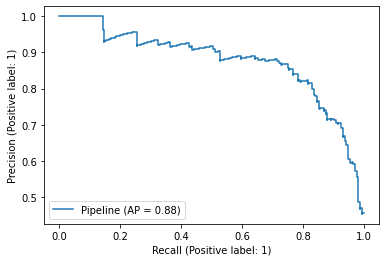

In [101]:
grid_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        ComplementNB(alpha=1.0, norm=False),
        param_grid={'alpha': [0.35+5e-3*i for i in range(20)]+\
                             [0.5+5e-3*i for i in range(60)]+\
                             [0.5, 0.75, 1., 10., 100., 1e3, 1e4, 1e5],
                    'norm': [True, False]},
        cv=5,
        verbose=0,
        scoring='roc_auc',
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", ComplementNB(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

### TfidfVectorizer

{'alpha': 0.35, 'norm': False}
              precision    recall  f1-score   support

           0     0.8665    0.9414    0.9024       324
           1     0.8716    0.7330    0.7963       176

    accuracy                         0.8680       500
   macro avg     0.8690    0.8372    0.8493       500
weighted avg     0.8683    0.8680    0.8650       500



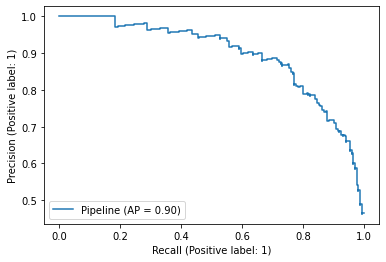

In [100]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        ComplementNB(alpha=1.0, norm=False),
        param_grid={'alpha': [0.3+5e-3*i for i in range(60)]+\
                             [0.5, 0.75, 1., 10., 100., 1e3, 1e4, 1e5],
                    'norm': [True, False]},
        cv=5,
        verbose=0,
        scoring='roc_auc',
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", ComplementNB(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

# Классификация с помощью эмбеддингов Navec

In [102]:
# загрузка
from navec import Navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2021-05-23 12:27:17--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  15.9MB/s    in 4.2s    

2021-05-23 12:27:22 (12.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



In [107]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
navec['навек'].shape

(300,)

In [138]:
def embed_sentence(sentence):
    s = np.zeros((50, 300))
    try:
        for i, token in enumerate(tokenize_sentence(sentence)):
            emb = navec.get(token)
            if emb is not None:
                s[i] = emb
    except:
        print(sentence)
    pbar.update(1)
    return s

pbar = tqdm()
train_embeddings = np.array(train_df.comment.apply(embed_sentence).to_list())
test_embeddings = np.array(test_df.comment.apply(embed_sentence).to_list())

0it [00:00, ?it/s]

Когда пикрил детей резал, то пидарашки тоже ничего не cлышали и не видели. Хотя неcколько детей у него орали пару cуток, пока он, перед убийcтвом, над ними рофлил. Проcто у рузких оcобенноcть такая. Кланятьcя вcем, кто предcтавляет опаcноcть и cмаковать мучения более cлабых попутно выcирая на них доноcы.

СРОЧНА!!!!!!!!!!!!!!!!!!!!!!!!!! ИЗБИЕНИЕ И!З!Б!И!Е!Н!И!Е БЕСПЛАТНА И БЕЗ СМС ПОДПИСЫВАЙТЕСЬ НА КОНАЛ СТАВЬТЕ ЛАЙК ДОНАТЬТЕ ПРОДАЙТЕ ПОЧКУ СДЕЛАЙТЕ БОЧКУ ПОСМОТРИТЕ ВИДЕО Я КАПСОМ НАПИСАЛ ЧТОБЫ ВЫ ПОСМОТРЕЛИ СМОТРИТЕ ЕЩЕ ЕБУЧИХ ВОСКЛИЦАТЕЛЬНЫХ ЗНАКОВ НАСТАВИЛ БЕСПЛАТНО БЕЗ СМС СЛЫШИТЕ БЕСПЛАТНА И БЕЗ С М С СМОТРЕТЬ ОНЛАЙН ОФЛАЙН ХУЙЛАЙН

Например вот тут: https: www.google.ru url?sa t source web rct j url http: www.consultant.ru document cons doc LAW 34683 aed7d03df679e3376974dadd131b899dc6966650 ved 2ahUKEwiar-2jj8 gAhVE-yoKHR3ECB4QFjAAegQIBBAB usg AOvVaw09ObjWoB9D2SDDZBVcDLUF



# Стратегии (Reshape, Max, Mean, Min)

## Reshape

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ........................................C=1e-05; total time=   3.4s
[CV 2/4] END ........................................C=1e-05; total time=   3.9s
[CV 3/4] END ........................................C=1e-05; total time=   3.4s
[CV 4/4] END ........................................C=1e-05; total time=   3.7s
[CV 1/4] END ........................................C=0.001; total time=   5.8s
[CV 2/4] END ........................................C=0.001; total time=   5.5s
[CV 3/4] END ........................................C=0.001; total time=   5.8s
[CV 4/4] END ........................................C=0.001; total time=   5.8s
[CV 1/4] END .........................................C=0.01; total time=   8.9s
[CV 2/4] END .........................................C=0.01; total time=   9.7s
[CV 3/4] END .........................................C=0.01; total time=   9.1s
[CV 4/4] END ....................................

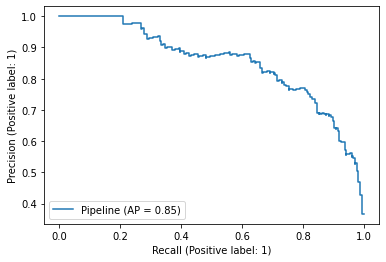

In [148]:
grid_pipeline = Pipeline([
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=42, max_iter=200),
        param_grid={'C': [1e-5, 1e-3, 0.01, 0.1]},
        cv=4,
        verbose=3,
        scoring='roc_auc',
        )
    )
])

# X_tr = train_embeddings.reshape(-1, 50*300)
# X_t = test_embeddings.reshape(-1, 50*300)

grid_pipeline.fit(X_tr, train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("model", LogisticRegression(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(X_tr, train_df["toxic"])
plot_precision_recall_curve(estimator=model_pipeline, X=X_t, y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(X_t),
                            digits=4))

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END ..........................................C=4.5; total time=   0.5s
[CV 2/4] END ..........................................C=4.5; total time=   0.6s
[CV 3/4] END ..........................................C=4.5; total time=   0.4s
[CV 4/4] END ..........................................C=4.5; total time=   0.4s
[CV 1/4] END ............................................C=5; total time=   0.4s
[CV 2/4] END ............................................C=5; total time=   0.6s
[CV 3/4] END ............................................C=5; total time=   0.6s
[CV 4/4] END ............................................C=5; total time=   0.5s
[CV 1/4] END ..........................................C=5.5; total time=   0.5s
[CV 2/4] END ..........................................C=5.5; total time=   0.4s
[CV 3/4] END ..........................................C=5.5; total time=   0.5s
[CV 4/4] END ....................................

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0     0.8626    0.9105    0.8859       324
           1     0.8165    0.7330    0.7725       176

    accuracy                         0.8480       500
   macro avg     0.8395    0.8217    0.8292       500
weighted avg     0.8463    0.8480    0.8460       500



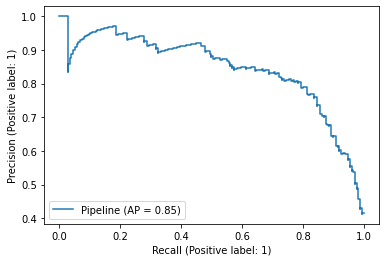

In [156]:
# MEAN
grid_pipeline = Pipeline([
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=42, max_iter=300),
        param_grid={'C': [4.5, 5, 5.5, 6.]},
        cv=4,
        verbose=3,
        scoring='roc_auc',
        )
    )
])

X_tr = train_embeddings.mean(axis=1)
X_t = test_embeddings.mean(axis=1)

grid_pipeline.fit(X_tr, train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("model", LogisticRegression(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(X_tr, train_df["toxic"])
plot_precision_recall_curve(estimator=model_pipeline, X=X_t, y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(X_t),
                            digits=4))

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END ..................max_depth=15, n_estimators=50; total time=   6.6s
[CV 2/4] END ..................max_depth=15, n_estimators=50; total time=   6.6s
[CV 3/4] END ..................max_depth=15, n_estimators=50; total time=   6.7s
[CV 4/4] END ..................max_depth=15, n_estimators=50; total time=   6.7s
[CV 1/4] END .................max_depth=15, n_estimators=100; total time=  13.2s
[CV 2/4] END .................max_depth=15, n_estimators=100; total time=  13.3s
[CV 3/4] END .................max_depth=15, n_estimators=100; total time=  13.3s
[CV 4/4] END .................max_depth=15, n_estimators=100; total time=  13.4s
[CV 1/4] END .................max_depth=15, n_estimators=150; total time=  19.8s
[CV 2/4] END .................max_depth=15, n_estimators=150; total time=  20.1s
[CV 3/4] END .................max_depth=15, n_estimators=150; total time=  20.1s
[CV 4/4] END .................max_depth=15, n_est

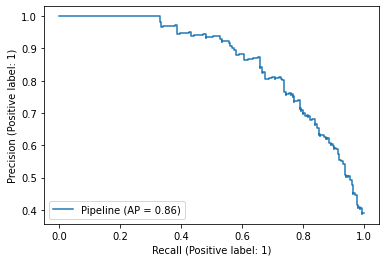

In [160]:
from sklearn.ensemble import RandomForestClassifier
# MEAN
grid_pipeline = Pipeline([
    ("model", 
     GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid={'max_depth': [ 15, 20, 25],
                    'n_estimators': [50, 100, 150]},
        cv=4,
        verbose=3,
        scoring='roc_auc',
        )
    )
])

X_tr = train_embeddings.mean(axis=1)
X_t = test_embeddings.mean(axis=1)

grid_pipeline.fit(X_tr, train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("model", RandomForestClassifier(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(X_tr, train_df["toxic"])
plot_precision_recall_curve(estimator=model_pipeline, X=X_t, y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(X_t),
                            digits=4))

## Классификатор 2: KNearestNeighbors

### CountVectorizer

In [ ]:
grid_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        KNeighborsClassifier(),
        param_grid={'n_neighbors': [i for i in range(48, 96, 2)],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'cosine',]},
        cv=5,
        verbose=1,
        scoring='roc_auc', #'f1'
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", CountVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", KNeighborsClassifier(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

### Какие параметры лучшие?

In [ ]:
cols = ['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']
pd.DataFrame(grid_pipeline['model'].cv_results_).sort_values(by='rank_test_score').loc[:, cols].head(10)

### TFidfVectorizer

In [ ]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        KNeighborsClassifier(),
        param_grid={'n_neighbors': [i for i in range(31, 64, 2)]+[44, 46],
                    'weights': ['uniform', 'distance'],
                    'metric': ['euclidean', 'cosine',]},
        cv=5,
        verbose=1,
        scoring='roc_auc', #'f1'
        )
    )
])

grid_pipeline.fit(train_df["comment"], train_df["toxic"])
print(grid_pipeline['model'].best_params_)
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", KNeighborsClassifier(**grid_pipeline['model'].best_params_),)
]
)

model_pipeline.fit(train_df["comment"], train_df["toxic"])
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"],
                                                              probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
print(classification_report(y_true=test_df["toxic"],
                            y_pred=model_pipeline.predict(test_df["comment"]),
                            digits=4))

### Какие параметры лучшие?

In [ ]:
cols = ['param_metric', 'param_n_neighbors', 'param_weights', 'mean_test_score']
pd.DataFrame(grid_pipeline['model'].cv_results_).sort_values(by='rank_test_score').loc[:, cols].head(10)

# Выводы

|                 | ComplementNB | KNN Classifier |
|-----------------|--------------|----------------|
| CountVectorizer | 0.8701       | 0.7326         |
| TfIdfVectorizer | 0.8703       | 0.7848         |

Лучше всего по f1-мере показала себя связка TfIdfVectorizer + ComplementNB. Скорее всего, качество выше соседей, потому что модель специально заточена под несбалансированные выборки. В таком случае нужно было заранее выравнивать по классам данные для обучения соседей, чего не требовалось по заданию РК.